In [1]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Image captioning

Image captioning is the task of predicting a caption for a given image. Common real world applications of it include
aiding visually impaired people that can help them navigate through different situations. Therefore, image captioning
helps to improve content accessibility for people by describing images to them.

This guide will show you how to:

* Fine-tune an image captioning model.
* Use the fine-tuned model for inference.

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install transformers datasets evaluate -q
pip install jiwer -q
```

We encourage you to log in to your Hugging Face account so you can upload and share your model with the community. When prompted, enter your token to log in:

In [2]:
# from huggingface_hub import notebook_login
# notebook_login()

## Load the Pokémon BLIP captions dataset

Use the 🤗 Dataset library to load a dataset that consists of {image-caption} pairs. To create your own image captioning dataset
in PyTorch, you can follow [this notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/GIT/Fine_tune_GIT_on_an_image_captioning_dataset.ipynb).

In [3]:
from datasets import load_dataset

ds = load_dataset("reach-vb/pokemon-blip-captions")
ds

/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [4]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

Let's visualize a couple of samples from the training set.

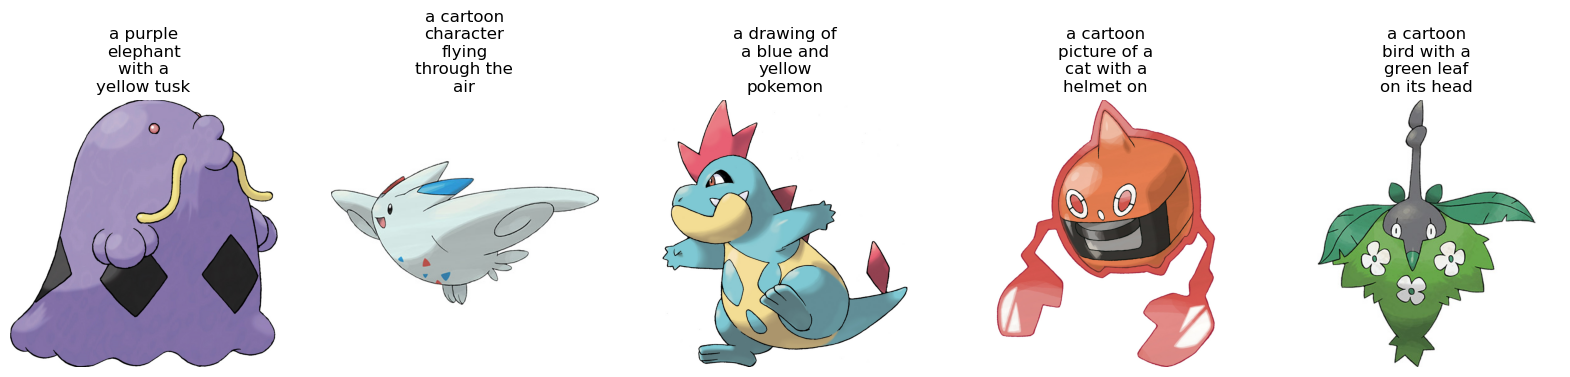

In [5]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## Preprocess the dataset

Since the dataset has two modalities (image and text), the pre-processing pipeline will preprocess images and the captions.

To do so, load the processor class associated with the model you are about to fine-tune.

In [6]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

The processor will internally pre-process the image (which includes resizing, and pixel scaling) and tokenize the caption.

In [7]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

With the dataset ready, you can now set up the model for fine-tuning.

## Load a base model

Load the ["microsoft/git-base"](https://huggingface.co/microsoft/git-base) into a [`AutoModelForCausalLM`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM) object.

In [8]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

## Evaluate

Image captioning models are typically evaluated with the [Rouge Score](https://huggingface.co/spaces/evaluate-metric/rouge) or [Word Error Rate](https://huggingface.co/spaces/evaluate-metric/wer). For this guide, you will use the Word Error Rate (WER).

We use the 🤗 Evaluate library to do so. For potential limitations and other gotchas of the WER, refer to [this guide](https://huggingface.co/spaces/evaluate-metric/wer).

In [9]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

## Train!

Now, you are ready to start fine-tuning the model. You will use the 🤗 [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) for this.

First, define the training arguments using [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    report_to="none"
)

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'fp8'

Then pass them along with the datasets and the model to 🤗 Trainer.

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


To start training, simply call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) on the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) object.

In [18]:
trainer.train()

Step,Training Loss,Validation Loss,Wer Score
50,0.026300,0.044181,20.547879
100,0.027600,0.042344,20.498182
150,0.030300,0.042287,0.946667
200,0.029400,0.042165,20.414545
250,0.028100,0.043227,20.484848
300,0.031700,0.043206,20.488485
350,0.040200,0.038477,20.465455
400,0.047200,0.038973,20.496970
450,0.036400,0.037987,20.480000
500,0.037600,0.039909,20.478788


KeyboardInterrupt: 

You should see the training loss drop smoothly as training progresses.

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [ ]:
trainer.push_to_hub()

## Inference

Take a sample image from `test_ds` to test the model.

In [ ]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/test_image_image_cap.png" alt="Test image"/>
</div>
    
Prepare image for the model.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

Call `generate` and decode the predictions.

In [ ]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

```bash
a drawing of a pink and blue pokemon
```

Looks like the fine-tuned model generated a pretty good caption!